In [80]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.graphics.tsaplots import plot_pacf

from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor

from joblib import Parallel, delayed
import warnings

import pickle

In [81]:
train = pd.read_csv("./data/train.csv", parse_dates=['date'], usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    infer_datetime_format=True)
train['date'] = train.date.dt.to_period('D')
train = train.set_index(['store_nbr', 'family', 'date']).sort_index()
oil = pd.read_csv("./data/oil.csv", parse_dates=['date'], infer_datetime_format = True, index_col = 'date').to_period('D')
holidays_events = pd.read_csv(
    './data/holidays_events.csv',
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')
stores = pd.read_csv("./data/stores.csv")

In [82]:
average_sales = train.groupby('date').mean()['sales']
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

Text(0.5, 0, '')

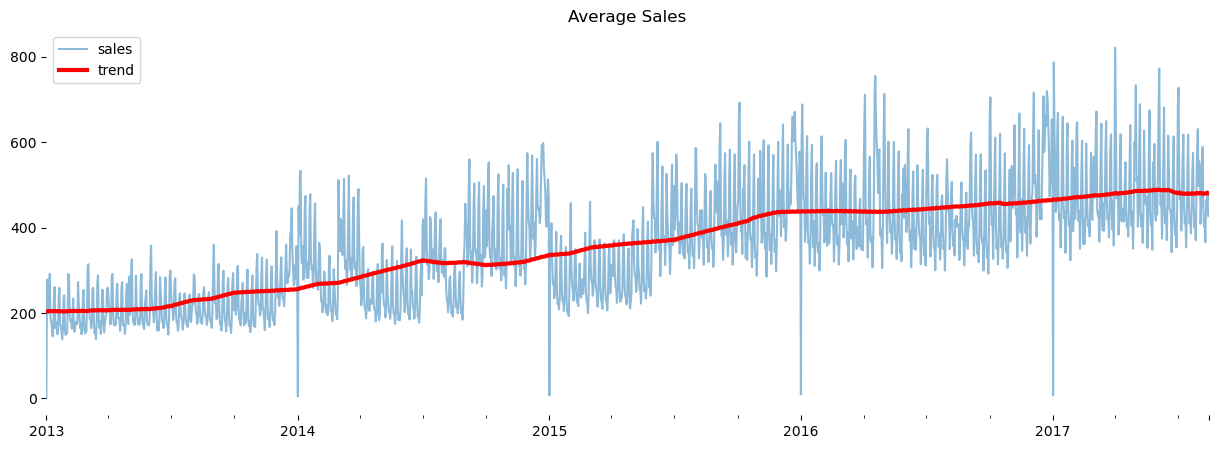

In [83]:
#plotting the trend
fig, ax = plt.subplots(figsize=(15,5))
average_sales.plot(alpha=0.5, title="Average Sales", ax=ax)
trend.plot(linewidth=3, label='trend', color='r', ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(False)
ax.legend();
ax.set_xlabel("")

In [84]:
y = average_sales.copy()
y = train.unstack(['store_nbr', 'family']) 

In [85]:
#Engineering the deterministic trend
dp = DeterministicProcess(
    index=y.index, 
    constant=True, 
    order=3,             # cubic trend was determined to be the most efficient
    drop=True,
)
X = dp.in_sample()
X.head()

,const,trend,trend_squared,trend_cubed
date,,,,
2013-01-01,1.0,1.0,1.0,1.0
2013-01-02,1.0,2.0,4.0,8.0
2013-01-03,1.0,3.0,9.0,27.0
2013-01-04,1.0,4.0,16.0,64.0
2013-01-05,1.0,5.0,25.0,125.0


In [86]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette(
        "husl",
        n_colors=X[period].nunique(),
    )
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

C:\Users\artur\AppData\Local\Temp\ipykernel_27380\551149587.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(
C:\Users\artur\AppData\Local\Temp\ipykernel_27380\551149587.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(


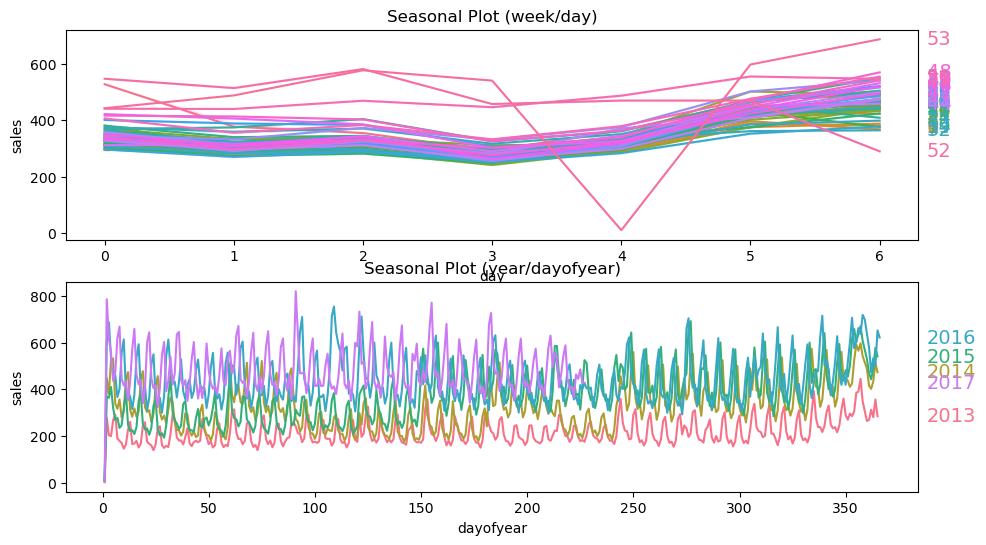

In [87]:
X = average_sales.to_frame()

# days within a week
X["day"] = X.index.dayofweek  
X["week"] = X.index.week  

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax1);

In [88]:
#plotting the periodogram to see the best frequency for the Fourier series
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

C:\Users\artur\AppData\Local\Temp\ipykernel_27380\2074560571.py:4: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


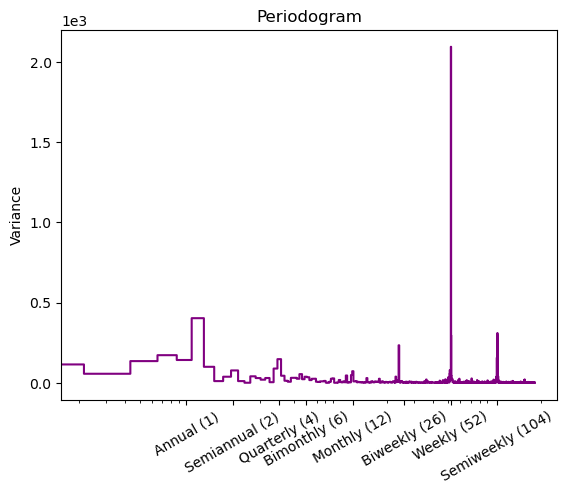

In [89]:
plot_periodogram(average_sales);

In [90]:
#Engineering the Fourier features of weekly frequency (based on the plot)
y = train.unstack(['store_nbr', 'family']).loc["2017"]

# Fourier features
fourier = CalendarFourier(freq='W', order=3)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    seasonal = False,            
    order=3,                     
    additional_terms=[fourier],  
    drop=True,                  
)

X = dp.in_sample()
X.head()

,const,trend,trend_squared,trend_cubed,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)"
date,,,,,,,,,,
2017-01-01,1.0,1.0,1.0,1.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969
2017-01-02,1.0,2.0,4.0,8.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-01-03,1.0,3.0,9.0,27.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969
2017-01-04,1.0,4.0,16.0,64.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490
2017-01-05,1.0,5.0,25.0,125.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521


Looking at the oil data and potentially adding oil lags

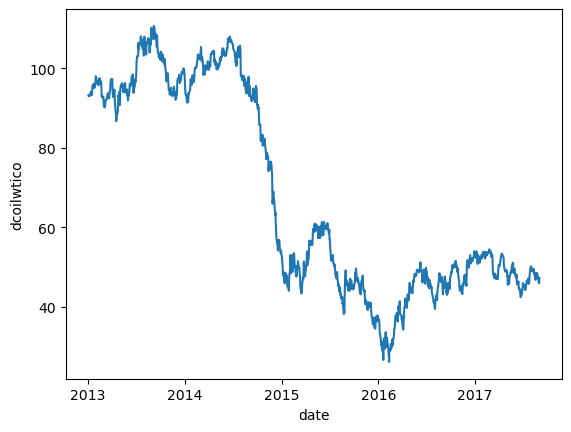

In [91]:
#Looking at the oil data and potentially adding oil lags
_ = sns.lineplot(data = oil.dcoilwtico.to_timestamp())

In [92]:
oil['avg_oil'] = oil['dcoilwtico'].rolling(7).mean()
calendar = pd.DataFrame(index = pd.date_range('2013-01-01','2017-08-31')).to_period('D')
calendar = calendar.join(oil.avg_oil)
calendar['avg_oil'].fillna(method = 'ffill', inplace = True)
calendar.dropna(inplace = True)
calendar.count()

avg_oil    1695
dtype: int64

C:\ProgramData\miniconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


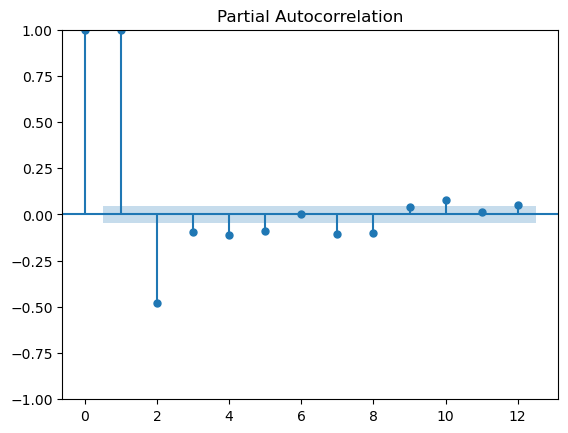

In [93]:
#Plotting partial autocorrelation of the lags to choose the best option
_ = plot_pacf(calendar.avg_oil, lags = 12)

In [94]:
#1-2 strong correlation, 3-5 week correlation, 6 correlation 0. Therefore, 5 lags will be used
n_lags = 5
for l in range(1, n_lags+1):
    calendar[f'oil_lags_{l}'] = calendar.avg_oil.shift(l)
calendar.dropna(inplace = True)
calendar.count()

avg_oil       1690
oil_lags_1    1690
oil_lags_2    1690
oil_lags_3    1690
oil_lags_4    1690
oil_lags_5    1690
dtype: int64

In [95]:
#now the last dataset - the holidays data
holidays_events.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [96]:
holidays_events = holidays_events[holidays_events.locale == 'National']
calendar =  calendar.join(holidays_events)

In [97]:
calendar['dofw'] = calendar.index.dayofweek

#wd - workdays
calendar['wd'] = 1

# excluding the weekends
calendar.loc[calendar.dofw > 4, 'wd'] = 0

#using the data from the holidays dataset
calendar.loc[calendar['type'] == 'Work Day', 'wd'] = 1
calendar.loc[calendar['type'] == 'Transfer', 'wd'] = 0
calendar.loc[calendar['type'] == 'Bridge', 'wd'] = 0
calendar.loc[(calendar['type'] == 'Holiday') & (calendar.transferred == False), 'wd'] = 0
calendar.loc[(calendar['type'] == 'Holiday') & (calendar.transferred == True), 'wd'] = 1

#one-hot encoding
calendar = pd.get_dummies(calendar, columns = ['dofw'], drop_first = True)
calendar.drop(['locale', 'locale_name', 'description', 'transferred', 'type'], axis = 1, inplace = True)

In [19]:
X = X.join(calendar)
X.head()

,const,trend,trend_squared,trend_cubed,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",...,oil_lags_3,oil_lags_4,oil_lags_5,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6
2017-01-01,1.0,1.0,1.0,1.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,...,51.801429,51.801429,51.801429,1,0,0,0,0,0,1
2017-01-02,1.0,2.0,4.0,8.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,51.801429,51.801429,51.801429,0,0,0,0,0,0,0
2017-01-03,1.0,3.0,9.0,27.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,...,51.801429,51.801429,51.801429,1,1,0,0,0,0,0
2017-01-04,1.0,4.0,16.0,64.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,...,51.801429,51.801429,51.801429,1,0,1,0,0,0,0
2017-01-05,1.0,5.0,25.0,125.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,...,51.801429,51.801429,51.801429,1,0,0,1,0,0,0


In [20]:
#The Model
#Voting Regression of Ridge, Support Vector Regression and XGBoost
SEED = 5

class CustomRegressor():

    def __init__(self, n_jobs=-1, verbose=0):

        self.n_jobs = n_jobs
        self.verbose = verbose

        self.estimators_ = None

    def _estimator_(self, X, y):

        warnings.simplefilter(action='ignore', category=FutureWarning)

        ridge = Ridge(fit_intercept=True, solver='auto', alpha=0.1, random_state=SEED)
        svr = SVR(C = 1, kernel = 'rbf')
        xgb = XGBRegressor(colsample_bytree=0.7, jobs = 2, learning_rate=0.1, max_depth=10, n_estimators=200)

        model = VotingRegressor([('ridge', ridge), ('svr', svr), ('xgb', xgb)])
        model.fit(X, y)

        return model

    def fit(self, X, y):
        from tqdm.auto import tqdm


        if self.verbose == 0 :
            self.estimators_ = Parallel(n_jobs=self.n_jobs,
                                  verbose=0,
                                  )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in range(y.shape[1]))
        else :
            print('Fit Progress')
            self.estimators_ = Parallel(n_jobs=self.n_jobs,
                                  verbose=0,
                                  )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in tqdm(range(y.shape[1])))
        return

    def predict(self, X):
        from tqdm.auto import tqdm
        if self.verbose == 0 :
            y_pred = Parallel(n_jobs=self.n_jobs,
                              verbose=0)(delayed(e.predict)(X) for e in self.estimators_)
        else :
            print('Predict Progress')
            y_pred = Parallel(n_jobs=self.n_jobs,
                              verbose=0)(delayed(e.predict)(X) for e in tqdm(self.estimators_))

        return np.stack(y_pred, axis=1)

In [21]:
model = CustomRegressor(n_jobs=-1, verbose=1)
model.fit(X, y)

C:\ProgramData\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fit Progress


100%|██████████████████████████████████████████████████████████████████████████████| 1782/1782 [02:16<00:00, 13.01it/s]


In [22]:
filename = 'model.sav'
pickle.dump(model, open(filename, 'wb'))

**Prediction**

In [98]:
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'

X_test.tail()
X_test = X_test.join(calendar)
X_test.head()

,const,trend,trend_squared,trend_cubed,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",...,oil_lags_3,oil_lags_4,oil_lags_5,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6
2017-08-16,1.0,228.0,51984.0,11852352.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,...,49.140000,49.140000,49.140000,1,0,1,0,0,0,0
2017-08-17,1.0,229.0,52441.0,12008989.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,...,48.934286,49.140000,49.140000,1,0,0,1,0,0,0
2017-08-18,1.0,230.0,52900.0,12167000.0,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,...,48.648571,48.934286,49.140000,1,0,0,0,1,0,0
2017-08-19,1.0,231.0,53361.0,12326391.0,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,...,48.281429,48.648571,48.934286,0,0,0,0,0,1,0
2017-08-20,1.0,232.0,53824.0,12487168.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,...,47.995714,48.281429,48.648571,0,0,0,0,0,0,1


In [101]:
y_pred = pd.DataFrame(model.predict(X_test).clip(0.0), index=X_test.index, columns=y.columns)
y_pred = y_pred.stack(['store_nbr', 'family'])

y_pred.head()

Predict Progress


100%|██████████████████████████████████████████████████████████████████████████████| 1782/1782 [00:28<00:00, 62.47it/s]


sales
           store_nbr family                  
2017-08-16 1         AUTOMOTIVE  3.919715e+00
                     BABY CARE   1.296192e-10
                     BEAUTY      3.983368e+00
                     BEVERAGES   2.194006e+03
                     BOOKS       1.422523e-01

In [104]:
sub = pd.read_csv('./data/sample_submission.csv')
sub['sales'] = y_pred.values
sub.to_csv('./data/sample_submission.csv', index = False)